# 10.4 Deep Field Simulations of the WFI

In the next step of the tutorial we will simulate and analyse deep field observations with the Athena WFI. We
separate this into the generation of the simulation input (Sect. 10.4.1), which is fully independent of the chosen
instrument, followed by an observation with all four chips of the WFI (Sect. 10.4.2). Of course, this second step
can also be done with any other satellite and detector by simply replacing the chosen XML files.

In [1]:
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
import numpy as np
import os
import time
import tempfile

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import run_comm
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)



In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
SIMPUT = os.environ["SIMPUT"]
xmldir = f"{SIXTE}/share/sixte/instruments/athena-wfi/wfi_wo_filter"

xml=f'{xmldir}/ld_wfi_ff_all_chips.xml'
xml0="{}/ld_wfi_ff_chip0.xml".format(xmldir)
xml1="{}/ld_wfi_ff_chip1.xml".format(xmldir)
xml2="{}/ld_wfi_ff_chip2.xml".format(xmldir)
xml3="{}/ld_wfi_ff_chip3.xml".format(xmldir)

## 10.4.1 SIMPUT for a Large Field

### Creating a SIMPUT for several sources with simputfile

(We'll use the spectral file *mcrab.xcm* that we created in previous tutorials)

In [3]:
simpar="XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes"
ra = [40.21, 40.31, 40.12, 40.27, 40.29, 40.33]
dec = [12.82, 12.83, 12.73, 12.81, 12.73, 12.81]
src_flux = [8.3e-12, 2.3e-11, 6.3e-12, 4.1e-12, 3.2e-11, 1.3e-11]
l = 0
for i, j, k in zip(ra, dec, src_flux):
    sim_file = f"src_0{l}.fits"
    comm = (f"simputfile RA={i} Dec={j} srcFlux={k} Simput={sim_file} {simpar}")
    #print(comm)
    run_comm(comm, "Creating simput file for several sources")
    l = l + 1


Creating simput file for several sources
simputfile RA=40.21 Dec=12.82 srcFlux=8.3e-12 Simput=src_00.fits XSPECFile=mcrab.xcm Emin=0.5 Emax=10.0 clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw  ;              0.2      0.001          0          0     100000      1e+06  ;          

#### Now that we have created the SIMPUT files for single sources, we merge them into a single file using `simputmerge`:

In [4]:
# Merge the simput files

opt="clobber=yes FetchExtensions=yes" 
#The keyword FetchExtensions is set to yes, in order to combine all available information in one file in the end

infile1 = "src_00.fits"
infile2 = "src_01.fits"
nfiles = len(ra) # from 00 to 05
for i in range(nfiles-1):
    if i == nfiles-2:
        outfile = "merged_simput.fits"
    else:
        outfile = f"m_src_0{i+1}.fits"
    comm = (f"simputmerge {opt} Infile1={infile1} Infile2={infile2} Outfile={outfile}")
    #print(comm)
    run_comm(comm,f'Merginig {infile1} and {infile2} into {outfile}')
    infile2 = outfile
    infile1 = f"src_0{i+2}.fits"


Merginig src_00.fits and src_01.fits into m_src_01.fits
simputmerge clobber=yes FetchExtensions=yes Infile1=src_00.fits Infile2=src_01.fits Outfile=m_src_01.fits

merging simput files ...
100%

cleaning up ...
finished successfully!

Merginig src_02.fits and m_src_01.fits into m_src_02.fits
simputmerge clobber=yes FetchExtensions=yes Infile1=src_02.fits Infile2=m_src_01.fits Outfile=m_src_02.fits

merging simput files ...
150%

cleaning up ...
finished successfully!

Merginig src_03.fits and m_src_02.fits into m_src_03.fits
simputmerge clobber=yes FetchExtensions=yes Infile1=src_03.fits Infile2=m_src_02.fits Outfile=m_src_03.fits

merging simput files ...
200%

cleaning up ...
finished successfully!

Merginig src_04.fits and m_src_03.fits into m_src_04.fits
simputmerge clobber=yes FetchExtensions=yes Infile1=src_04.fits Infile2=m_src_03.fits Outfile=m_src_04.fits

merging simput files ...
250%

cleaning up ...
finished successfully!

Merginig src_05.fits and m_src_04.fits into merged_s

We have now created a very basic source catalogue called *merged_simput.fits*, which we can analyse with
the WFI. You can also have a look at the SIXTE homepage and into the later sections of this tutorial for more
complicated realistic examples.

## 10.4.2 Simple Wide Field Simulations

In the following we want to simulate an observation that uses all four chips of the WFI. This approach requires
us to simulate four chips at once which can be done by providing an XML file to sixtesim which contains all
four chips. We store the XML filename in a variable in order to increase readability of the tutorial.


### Viewing the chip geometry with `xml2svg`

The parameters of the `SVGWidth` and Border are given in units of mm. The optional parameter of `DrawN`
specifies how many single pixels (in red) are drawn. These pixels are drawn in the readout-direction.

In [5]:
svg_file = "athenawfi_fullframe.svg"
pdf_file = "athenawfi_fullframe.pdf"

comm = (f"xml2svg XMLFiles='{xml0};{xml1};{xml2};{xml3}' SVGWidth=3000 Border=10 SVGName={svg_file}")
#print(comm)
run_comm(comm, 'Getting chip geometry')


Getting chip geometry
xml2svg XMLFiles='/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip0.xml;/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip1.xml;/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip2.xml;/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip3.xml' SVGWidth=3000 Border=10 SVGName=athenawfi_fullframe.svg
4 XML files were found:
#1: /Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip0.xml
#2: /Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip1.xml
#3: /Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip2.xml
#4: /Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_chip3.xml
Load /Users/jessicaplanelles/simput/share/sixte/instruments/ath

#### Convert SVG file to PDF
To do this, you should have ImageMagick installed on your machine:
- On macOS, you can install it with Homebrew:
  brew install imagemagick
- On Linux (Debian/Ubuntu):
  sudo apt-get install imagemagick

In [6]:
run_comm(f"magick {svg_file} {pdf_file}", 'Converting svg to pdf')

Converting svg to pdf
magick athenawfi_fullframe.svg athenawfi_fullframe.pdf


Another option is importing these libraries

In [7]:
from IPython.display import SVG, display
from IPython.core.display import HTML
display(HTML(f'<img src="{svg_file}" width="500" height="500">'))

### Simulating the four WFI chips with `sixtesim`

In [8]:
xml=f'{xmldir}/ld_wfi_ff_all_chips.xml'
RApoint = 40.21
DECpoint = 12.77
comm = (f"sixtesim XMLFile={xml} RA={RApoint} Dec={DECpoint} Prefix='sim_' " +
        f"Simput=merged_simput.fits EvtFile=evt.fits Exposure=1000 clobber=yes ")
#print(comm)
run_comm(comm, 'Simulating 4 chips')

Simulating 4 chips
sixtesim XMLFile=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml RA=40.21 Dec=12.77 Prefix='sim_' Simput=merged_simput.fits EvtFile=evt.fits Exposure=1000 clobber=yes 
initialize ...
Seed = 1666593019
try to load all spectra ('merged_simput.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'merged_simput.fits[SPECTRUM,1][NAME=='spec_0000000002']' does not cover the full energy range of the ARF! ***

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'merged_simput.fits[SPECTRUM,1][NAME=='spec_0000000005']' does not cover the full energy range of the ARF! ***

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'merged_simput.fits[SPECTRUM,1][NAME=='spec_0000000004']' does not cover the full energy range of the ARF! ***

*** Warning in con

Note that intermediate products such as the raw event file and impact list can be generated when giving the
respective names as keywords (`RawData` and `ImpactList`). `RA` and `Dec` specify the pointing of the satellite in
degrees. Make sure that these values point the satellite to a location that contains a source!

#### Using the FTOOL `ftmerge`, the event files can be easily merged into one larger event file.

In [9]:
#  merging the 4 chips
combined_file = 'sim_combined_evt.fits'
comm = (f'ftmerge sim_chip0_evt.fits,sim_chip1_evt.fits,sim_chip2_evt.fits,sim_chip3_evt.fits {combined_file} clobber=yes')
run_comm(comm, 'Merging 4 chips')

# To inspect the final evt file (same effect as fv/fstrct/fdump command)
f = fits.open(combined_file)
f.info()
print(f[1].columns.names)

Merging 4 chips
ftmerge sim_chip0_evt.fits,sim_chip1_evt.fits,sim_chip2_evt.fits,sim_chip3_evt.fits sim_combined_evt.fits clobber=yes
Filename: sim_combined_evt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  EVENTS        1 BinTableHDU    120   179827R x 16C   [D, J, J, J, E, I, I, D, D, 2J, 2J, I, J, I, 9E, 9J]   
  2  STDGTI        1 BinTableHDU     25   1R x 2C   [D, D]   
['TIME', 'FRAME', 'PHA', 'PI', 'SIGNAL', 'RAWX', 'RAWY', 'RA', 'DEC', 'PH_ID', 'SRC_ID', 'TYPE', 'NPIXELS', 'PILEUP', 'SIGNALS', 'PHAS']


### Create an image of the full WFI detector with `imgev`

We choose `NAXIS1` and `NAXIS2` to accomodate the four 512 by 512 pixel chips of the detector, adding additional pixels to account for the gap between the chips. `CRVAL1` and `CRVAL2` give the aim point of the satellite, corresponding to `RA`, and `Dec`, respectively. In detector
coordinates of the current setup this corresponds to the pixel coordinates CRPIX1 and CRPIX2 as given above.
Finally, `CDELT1` and `CDELT2` are the pixel size in degrees (i.e., for the WFI, 130 µm, projected onto the sky
using the 12 m focal length of the telescope). Note that the coordinate system is defined such that `CDELT1` has a
negative increment. 

**Important note**: By simply changing the aim point of the satellite in the above command, it can be re-used for
any WFI observation with the full four chips.

In [10]:
img_file = 'sim_combined_img.fits'
comm = (f"imgev EvtFile={combined_file} Image={img_file} CoordinateSystem=0 Projection='TAN' NAXIS1=1063 NAXIS2=1063 " +
        f"CUNIT1='deg' CUNIT2='deg' CRVAL1={RApoint} CRVAL2={DECpoint} CRPIX1=532 CRPIX2=532 " + 
        f"CDELT1=-6.207043e-4 CDELT2=6.207043e-4 history=true clobber=yes")
#print(comm)
run_comm(comm, "Creating image of the WFIdetector")

Creating image of the WFIdetector
imgev EvtFile=sim_combined_evt.fits Image=sim_combined_img.fits CoordinateSystem=0 Projection='TAN' NAXIS1=1063 NAXIS2=1063 CUNIT1='deg' CUNIT2='deg' CRVAL1=40.21 CRVAL2=12.77 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-4 CDELT2=6.207043e-4 history=true clobber=yes
initialize ...
open event file 'sim_combined_evt.fits' ...
finished successfully!



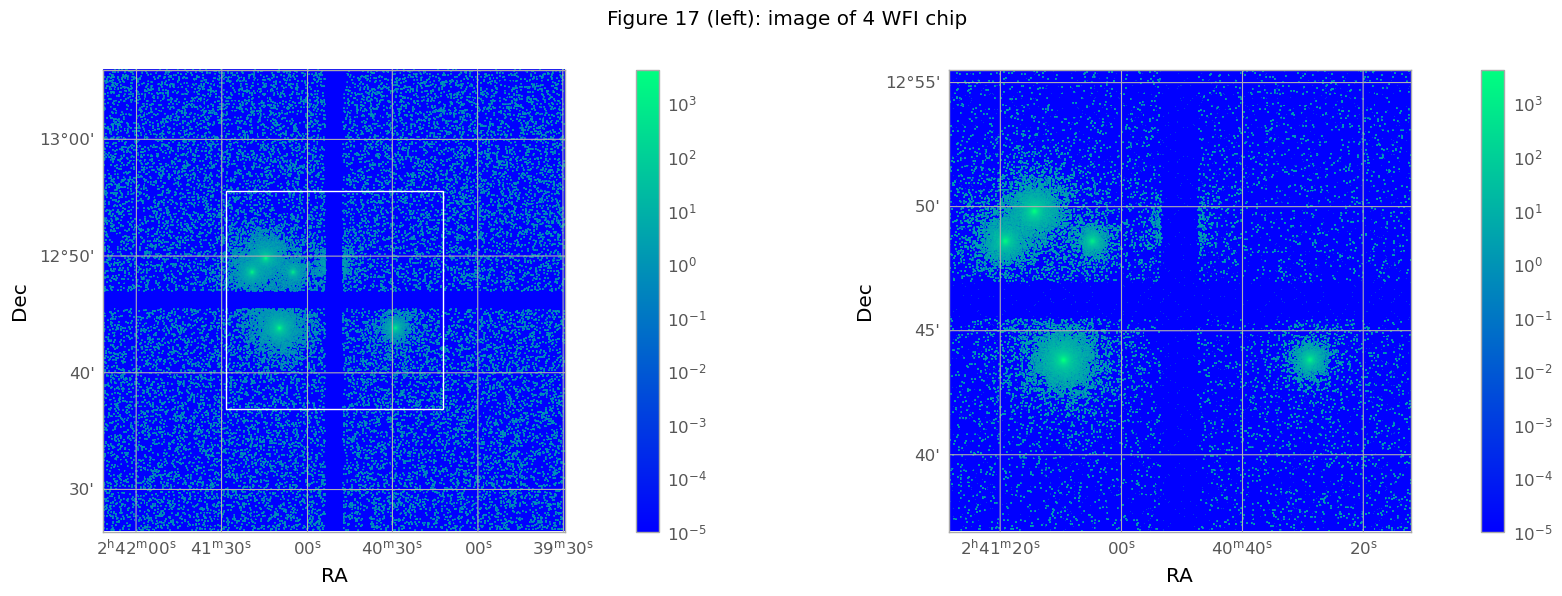

In [11]:
image_data = fits.getdata(img_file, ext=0)
hdu = fits.open(img_file)[0]
wcs = WCS(hdu.header)
crpix = int(wcs.wcs.crpix[0])

position = (crpix, crpix)
size = (500, 500)     # pixels
cutout = Cutout2D(image_data, position, size, wcs=wcs)

fig = plt.figure(figsize=(20,6))
fig.suptitle("Figure 17 (left): image of 4 WFI chip")
cmap = plt.cm.winter

#plot image
ax = fig.add_subplot(1, 2, 1, projection=wcs)
im = ax.imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=1e-5, vmax=np.max(image_data), clip=True), origin="lower")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
fig.colorbar(im,ax=ax, pad=0.1)
cutout.plot_on_original(color='white')

#plot image right: zoom
ax = fig.add_subplot(1, 2, 2, projection=cutout.wcs)
im = ax.imshow(cutout.data, cmap=cmap, norm=colors.LogNorm(vmin=1e-5, vmax=np.max(image_data), clip=True), origin="lower")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
fig.colorbar(im,ax=ax, pad=0.1)


### Create a spectrum with `makespec`

In [12]:
# Create spectrum for lower source at right side
combined_file = 'sim_combined_evt.fits'
spec_file = 'sim_combined_spec.pha'
comm = (f"makespec EvtFile={combined_file} Spectrum={spec_file} clobber=yes RSPPath={xmldir} EventFilter='(RA>40.10 && RA<40.14) && Dec>12.71 && Dec<12.75'")
#print(comm)
run_comm(comm, 'Generating spectrum')

Generating spectrum
makespec EvtFile=sim_combined_evt.fits Spectrum=sim_combined_spec.pha clobber=yes RSPPath=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter EventFilter='(RA>40.10 && RA<40.14) && Dec>12.71 && Dec<12.75'
SIXTE version 3.0.4
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 1752646921
calculate spectrum ...
store spectrum ...
ARF is 
/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf
RMF is 
/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf



In [13]:
# shorten ARF and RMF paths
f = fits.open(spec_file)
rmf = f[1].header['RESPFILE']
arf = f[1].header['ANCRFILE']
f.close()

## create symlinks if not already done (uncomment)
#run_comm('ln -s {}'.format(rmf), 'Linking to working directory')
#run_comm('ln -s {}'.format(arf), 'Linking to working directory')

# strip path in keywords to avoid very long values and update header
#rmf = os.path.basename(rmf)
#arf = os.path.basename(arf)
#f = fits.open(spec_file, 'update')
#f[1].header['RESPFILE'] = rmf
#f[1].header['ANCRFILE'] = arf
#f.close()

### Rebin spectral data with `grppha`

In [14]:
binspec = "sim_combined_spec_rebin.pha"
comm = (f"grppha infile={spec_file} outfile={binspec} clobber=yes comm='group min 20 & exit'")
run_comm(comm, "Rebinning spectrum")

Rebinning spectrum
grppha infile=sim_combined_spec.pha outfile=sim_combined_spec_rebin.pha clobber=yes comm='group min 20 & exit'
 
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - Athena          Mission/Satellite name
  INSTRUME  - WFI             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 1000.0          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.0000          Background scaling factor
  BACKFILE  - NONE            Associated background file
  CORRSCAL  - 0.0000          Correlation scaling factor
  CORRFILE  - NONE            Associated correlation file
  RESPFILE  - /Users/jessicaplanelles/simput/share/sixte/instruments...
  ANCRFILE  -


1 spectrum  in use
 
Spectral Data File: sim_combined_spec_rebin.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.272e+01 +/- 1.128e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-372
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf


ignore:   128 channels ignored from  source number 1


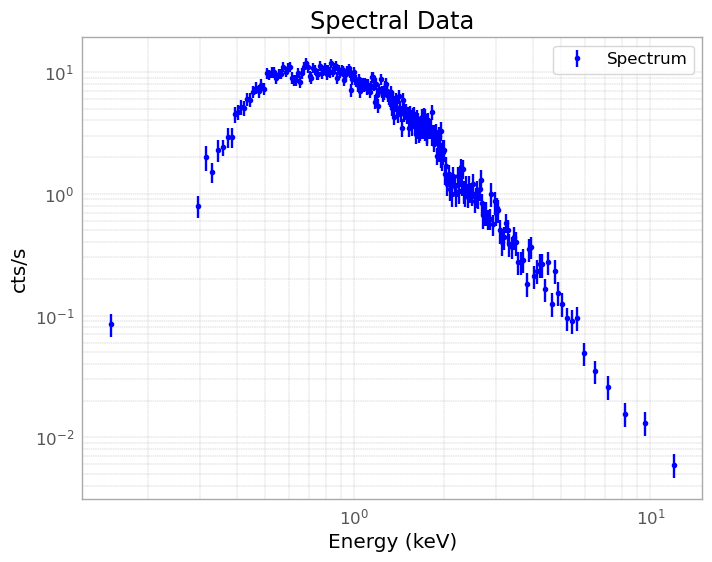

In [15]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()
#Plot.device = "/xs" # Disable the visualization in XSPEC
Plot.xAxis="keV"
s1 = Spectrum(binspec)
AllData.ignore("bad")
Plot("ldata")
Plot.device = "/null" 
energies = Plot.x()
counts = Plot.y()
errors = Plot.yErr()

plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Spectrum", color='blue', markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("cts/s")
plt.title("Spectral Data")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.3)
plt.show()

## 10.4.3 Simulating the Chandra Deep Field South

Download Files: https://www.sternwarte.uni-erlangen.de/~sixte/simput/CDFS_combined_simput.tgz


Generally, more complicated source catalogs will need to be assembled with scripts. One example is the
Chandra Deep Field South (CDFS), which has been created by using the data provided by Lehmer et al. (2005)
(CDFS_cat_lehmer.fits). Additionally, we will also use the background galaxy clusters as described by
Finoguenov et al. (2015) (CDFS_cat_galaxies.fits).

### Running simulation for all chips with `sixtesim` tool 

In [16]:
xml=f'{xmldir}/ld_wfi_ff_all_chips.xml'
RApoint = 53.13
DECpoint = -27.8
prefix = "cdfs_"
comm = (f"sixtesim XMLFile={xml} RA={RApoint} Dec={DECpoint} " +
        f"Prefix={prefix} Simput=CDFS_cat_lehmer.fits,CDFS_cat_galaxies.fits EvtFile=evt.fits Exposure=5000 clobber=yes")
#print(comm)
run_comm(comm, 'Simulating 4 chips')  

Simulating 4 chips
sixtesim XMLFile=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml RA=53.13 Dec=-27.8 Prefix=cdfs_ Simput=CDFS_cat_lehmer.fits,CDFS_cat_galaxies.fits EvtFile=evt.fits Exposure=5000 clobber=yes
initialize ...
Seed = 1753272232
try to load all spectra ('crab_spectrum.fits[SPECTRUM]') into cache ...
try to load all spectra ('cluster_spectrum.fits[SPECTRUM]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|

*** Warning in openNthSpecCache: The FLUXDENSITY column in file crab_spectrum.fits extension SPECTRUM is not called FLUXDENSITY, trying FLUX now! ***

*** Warning in openNthSpecCache: The FLUXDENSITY column in file cluster_spectrum.fits extension SPECTRUM is not called FLUXDENSITY, trying FLUX now! ***

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'cluster_spectrum.fits[SPECTRUM]' does not cover the full energ

### Merging the event files with `ftmerge`

In [17]:
combined_file = f'{prefix}combined_evt.fits'
comm = (f"ftmerge {prefix}chip0_evt.fits,{prefix}chip1_evt.fits,{prefix}chip2_evt.fits,{prefix}chip3_evt.fits " +
        f"{combined_file} clobber=yes")
run_comm(comm,'Merging 4 chips')
# To inspect the final evt file (similar to fstruct/fv/fdump commands)
f = fits.open(combined_file)
f.info()
print(f[1].columns.names)

Merging 4 chips
ftmerge cdfs_chip0_evt.fits,cdfs_chip1_evt.fits,cdfs_chip2_evt.fits,cdfs_chip3_evt.fits cdfs_combined_evt.fits clobber=yes
Filename: cdfs_combined_evt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  EVENTS        1 BinTableHDU    120   137038R x 16C   [D, J, J, J, E, I, I, D, D, 2J, 2J, I, J, I, 9E, 9J]   
  2  STDGTI        1 BinTableHDU     25   1R x 2C   [D, D]   
['TIME', 'FRAME', 'PHA', 'PI', 'SIGNAL', 'RAWX', 'RAWY', 'RA', 'DEC', 'PH_ID', 'SRC_ID', 'TYPE', 'NPIXELS', 'PILEUP', 'SIGNALS', 'PHAS']


### Creating image of the detector with `imgev`

In [18]:
img_file = '{}combined_img.fits'.format(prefix)
comm = (f"imgev EvtFile={combined_file} Image={img_file} CoordinateSystem=0 Projection='TAN' NAXIS1=1063 NAXIS2=1063 " +
        f"CUNIT1='deg' CUNIT2='deg' CRVAL1={RApoint} CRVAL2={DECpoint} CRPIX1=532 CRPIX2=532 " + 
        f"CDELT1=-6.207043e-4 CDELT2=6.207043e-4")
#print(comm)
run_comm(comm, "Creating Deep Field Image")

Creating Deep Field Image
imgev EvtFile=cdfs_combined_evt.fits Image=cdfs_combined_img.fits CoordinateSystem=0 Projection='TAN' NAXIS1=1063 NAXIS2=1063 CUNIT1='deg' CUNIT2='deg' CRVAL1=53.13 CRVAL2=-27.8 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-4 CDELT2=6.207043e-4
initialize ...
open event file 'cdfs_combined_evt.fits' ...
finished successfully!



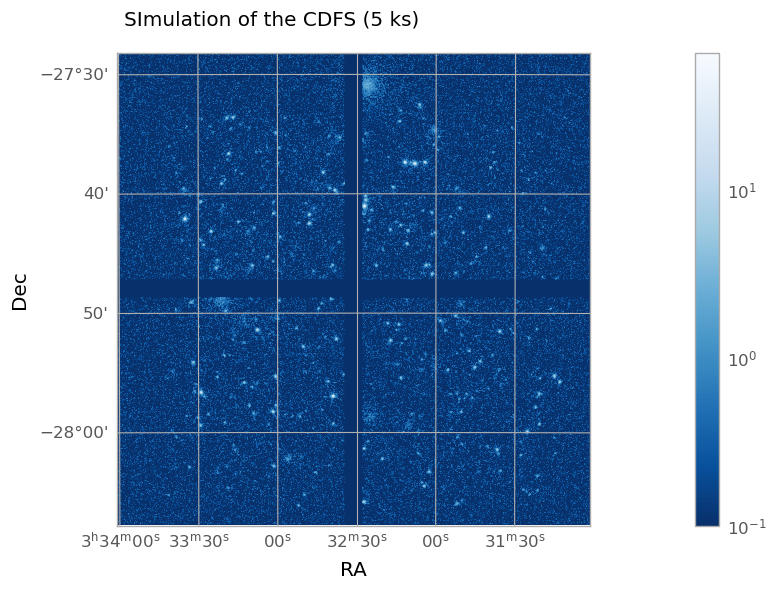

In [19]:
image_data = fits.getdata(img_file, ext=0)
hdu = fits.open(img_file)[0]
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(12,6))
fig.suptitle("SImulation of the CDFS (5 ks)")
cmap = plt.cm.Blues_r

#plot image
ax = fig.add_subplot(1, 1, 1, projection=wcs)
im = ax.imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=np.max(image_data), clip=True), origin="lower")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
fig.colorbar(im,ax=ax, pad=0.1)
plt.tight_layout();

## 10.4.4 Dithering and Exposure Map

In order to avoid to imprint the gaps between the chips in the data (see the figure above) the satellite will usually be
operated in a dithering mode. In SIXTE, a time-varying pointing of the satellite can be specified with an attitude
file. The attitude file is a FITS file which for a given `Time` (in seconds) contains the position of the satellite
`RA` and `Dec`. Additionally the rotation of the satellite can be specified by the additional column `beta_sat`
(it will rotate the chip in the observer plane). 

### Generate an Attitude file suited for CDFS with `attgen_dither` tool

In [20]:
att_file = "attitude_lissajous.fits"
comm = (f"attgen_dither Attitude={att_file} Amplitude=0.035 SrcRA={RApoint} SrcDec={DECpoint} Exposure=5000")
#print(comm)
run_comm(comm, "Generating Attitude File for CDFS")

Generating Attitude File for CDFS
attgen_dither Attitude=attitude_lissajous.fits Amplitude=0.035 SrcRA=53.13 SrcDec=-27.8 Exposure=5000
cleaning up ...
finished successfully!



### Obtaining exposure map: 5 ks snapshot of the attitude at a lower time resolution with `exposure_map` tool

To generate an exposure map, the following parameters need to be specified:

- **Vignetting File**: The flux from sources at the outer regions of the field of view is lower than at the center. This is defined by the `Vignetting` keyword.
  
- **Attitude File**: The satellite's position and orientation are specified using the `Attitude` keyword.
  
- **Exposure Map Filename**: The filename of the output map is set by the `Exposuremap` keyword.

#### Exposure Map Calculation
The exposure map calculation starts at **TSTART** with a time increment of **dt** and a duration defined by **timespan** (in seconds). 

- **Grid Definition**: The grid for the exposure map is specified via `WCS` keyrecords, similar to the **imgev** calls in previous sections.
  
- **Projection Type**: Defined by the **projection_type** argument, specifying the map projection to use.

- **Pixel Information**:
  - **NAXIS1 and NAXIS2**: Define the number of x- and y-pixels in the exposure map.
  - **CRVAL1 and CRVAL2**: Define the center of the map (pointing of the observation).
  - **CRPIX1 and CRPIX2**: Define the pixel coordinates corresponding to the map center.
  - **CDELT1 and CDELT2**: Define the pixel sizes in degrees. Note that **CDELT1** has a negative increment.

#### Calculation Time and Field of View (FOV)
- The calculation time scales linearly with the number of pixels in the resulting image.
- **FOV Diameter**: The `fov_diameter` keyword (in arcminutes) should be set. The exact geometry and size of the FOV are defined in the XML. 
  - It's recommended to set this to a conservative value (e.g., 70' for the WFI detector).


In [21]:
expo_map = 'expo_map.fits'
vig_file = f"{xmldir}/athena_vig_13rows_20231211.fits"
comm = (f'exposure_map Vignetting={vig_file} Attitude={att_file} Exposuremap={expo_map} XMLFile="{xml}" ' +
        f'fov_diameter=70 CoordinateSystem=0 projection_type=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg ' +
        f'CRVAL1={RApoint} CRVAL2={DECpoint} CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 ' + 
        f'TSTART=0 timespan=5000.000000 dt=100. chatter=3 clobber=true')
#print(comm)
run_comm(comm, 'Calculating exposure map')

Calculating exposure map
exposure_map Vignetting=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_vig_13rows_20231211.fits Attitude=attitude_lissajous.fits Exposuremap=expo_map.fits XMLFile="/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml" fov_diameter=70 CoordinateSystem=0 projection_type=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=53.13 CRVAL2=-27.8 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 TSTART=0 timespan=5000.000000 dt=100. chatter=3 clobber=true
### Warning: Geometry keyword not set in XML, will be set to default (rectangular array)!
### Warning: Geometry keyword not set in XML, will be set to default (rectangular array)!
### Warning: Geometry keyword not set in XML, will be set to default (rectangular array)!
### Warning: Geometry keyword not set in XML, will be set to default (rectangular array)!
calculate the exposure map ...
100 %

store exposure ma

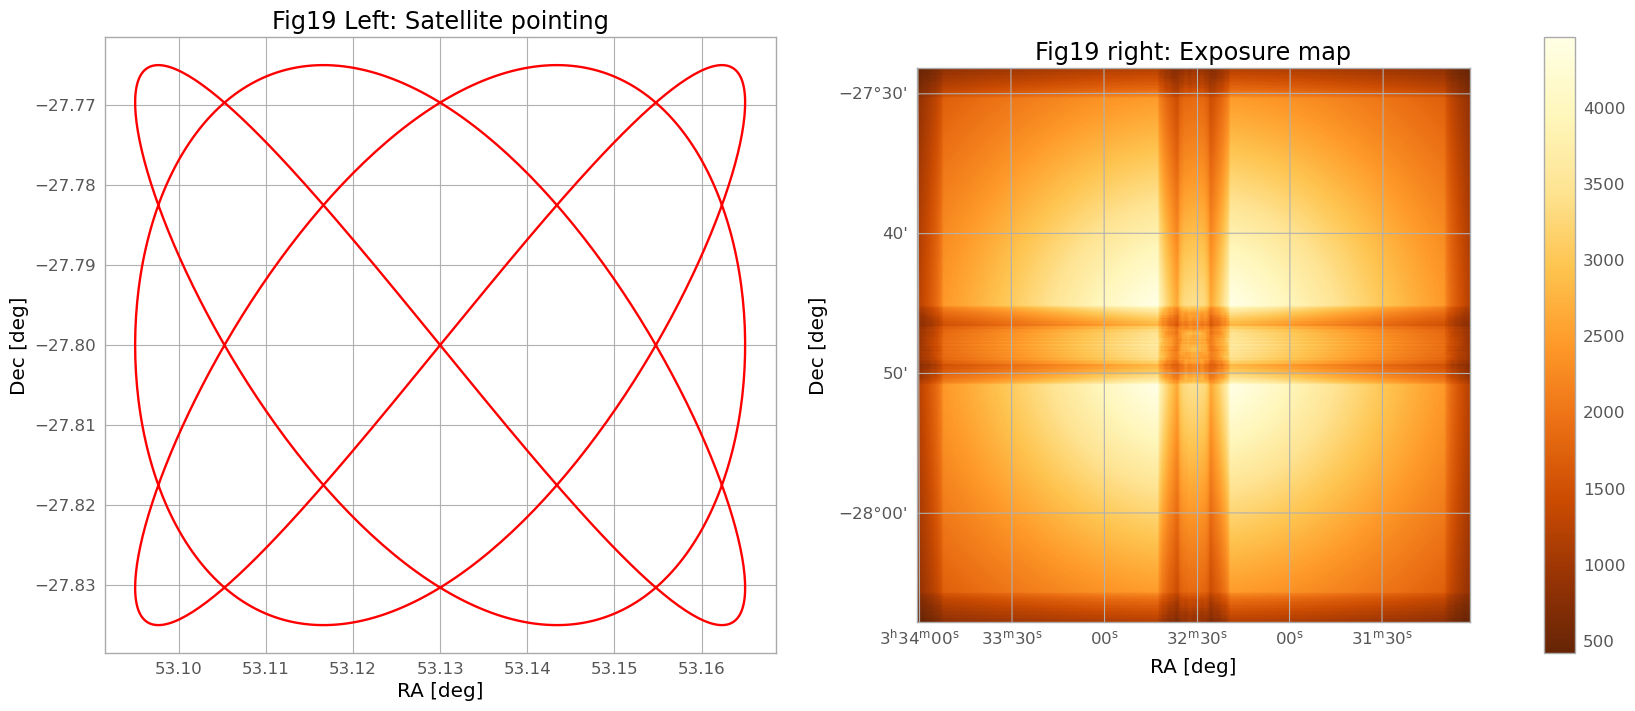

In [22]:
# plot attitude file 
# read coords of attitude file
from matplotlib import gridspec
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1.1], wspace=0.2,
                         hspace=0.5, height_ratios=[1,])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(spec[0])

f = fits.open(att_file)
ra = f[1].data['RA']
dec = f[1].data['Dec']
f.close()
ax.plot(ra, dec, 'r-')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.title.set_text('Fig19 Left: Satellite pointing')

#plot exposure map
f = fits.open(expo_map)
data = f[0].data
wcs = WCS(f[0].header)
f.close()
ax = fig.add_subplot(spec[1], projection=wcs)
cmap = plt.cm.YlOrBr_r
im = ax.imshow(data, cmap=cmap, origin='lower')
fig.colorbar(im,ax=ax, pad=0.1)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.title.set_text('Fig19 right: Exposure map');

### Run new simulation with `sixtesim`to remove the detector gaps

In [23]:
comm = (f'sixtesim Attitude={att_file} Prefix=c_att_ XMLFile={xml} '+ 
        f'Simput=CDFS_cat_lehmer.fits,CDFS_cat_galaxies.fits Exposure=5000 clobber=yes')
print(comm)
run_comm(comm, 'Simulating 4 chips')

sixtesim Attitude=attitude_lissajous.fits Prefix=c_att_ XMLFile=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml Simput=CDFS_cat_lehmer.fits,CDFS_cat_galaxies.fits Exposure=5000 clobber=yes
Simulating 4 chips
sixtesim Attitude=attitude_lissajous.fits Prefix=c_att_ XMLFile=/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_all_chips.xml Simput=CDFS_cat_lehmer.fits,CDFS_cat_galaxies.fits Exposure=5000 clobber=yes
initialize ...
using Attiude File: attitude_lissajous.fits
Seed = 2228257742
TIMEZERO keyword not given... continue
try to load all spectra ('crab_spectrum.fits[SPECTRUM]') into cache ...
try to load all spectra ('cluster_spectrum.fits[SPECTRUM]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|

*** Warning in openNthSpecCache: The FLUXDENSITY column in file crab_spectrum.fits extension SPEC

### Merge chips  with `ftmerge`

In [24]:
prefix="c_att_"
merged_combined_nogap = f'{prefix}combined_evt.fits'
comm = (f"ftmerge {prefix}chip0_none,{prefix}chip1_none,{prefix}chip2_none,{prefix}chip3_none " +
        f"{merged_combined_nogap} clobber=yes")
run_comm(comm, 'Merging 4 event files - no gaps')

Merging 4 event files - no gaps
ftmerge c_att_chip0_none,c_att_chip1_none,c_att_chip2_none,c_att_chip3_none c_att_combined_evt.fits clobber=yes


### Create image with `imgev`

In [25]:
img_file = f'{prefix}combined_img.fits'
comm = (f'imgev EvtFile={merged_combined_nogap} Image={img_file} CoordinateSystem=0 Projection=TAN NAXIS1=1063 ' +
        f'NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1={RApoint} CRVAL2={DECpoint} CRPIX1=532 CRPIX2=532 ' + 
        f'CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes')
#print(comm)
run_comm(comm, 'Creating no gaps image')

Creating no gaps image
imgev EvtFile=c_att_combined_evt.fits Image=c_att_combined_img.fits CoordinateSystem=0 Projection=TAN NAXIS1=1063 NAXIS2=1063 CUNIT1=deg CUNIT2=deg CRVAL1=53.13 CRVAL2=-27.8 CRPIX1=532 CRPIX2=532 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes
initialize ...
open event file 'c_att_combined_evt.fits' ...
finished successfully!



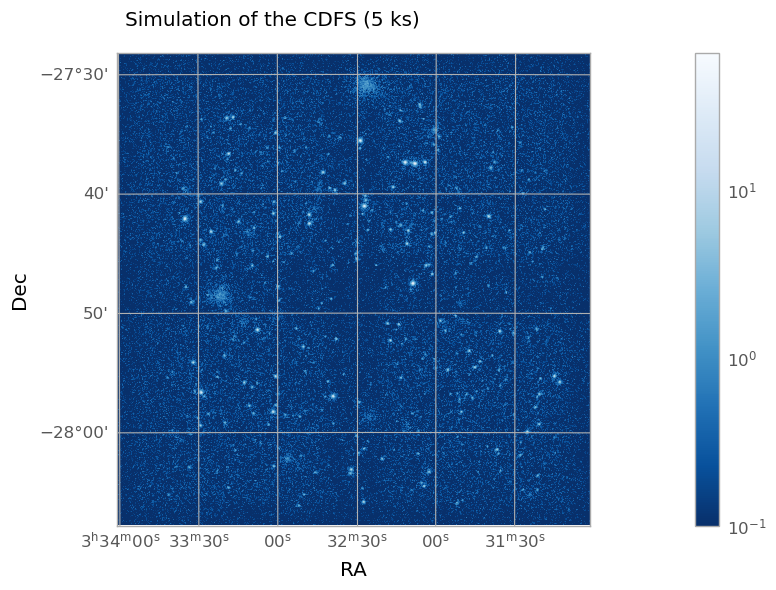

In [26]:
image_data = fits.getdata(img_file, ext=0)
hdu = fits.open(img_file)[0]
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(12,6))
fig.suptitle("Simulation of the CDFS (5 ks)")
cmap = plt.cm.Blues_r

#plot image
ax = fig.add_subplot(1, 1, 1, projection=wcs)
im = ax.imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.1, vmax=np.max(image_data), clip=True), origin="lower")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
fig.colorbar(im,ax=ax, pad=0.1)
plt.tight_layout();

## The next steps
### Exposure correction 
The most important step missing above is the exposure correction of the final CDFS simulation. 
Simulating the full 80 ksec observation and an exposure map for the same time at a finer grid will
yield the necessary files to perform this correction. Then, using an external analysis software of your choice
(python, ISIS, IDL, . . . ) both files need to be loaded with their respective WCS coordinates. For each pixel in
the final image you can then look up the exposure from the map and correct for it.
### Adding background 
Additional background (such as cosmic X-ray background) can be easily added with an
extra SIMPUT file. A selection of such files can be found at the SIMPUT section of the SIXTE homepage.